# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

Инструкция по выполнению проекта    
1.	Откройте файл с данными и изучите его. Путь к файлу: /datasets/users_behavior.csv. Скачать датасет    
2.	Разделите исходные данные на обучающую, валидационную и тестовую выборки.    
3.	Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.    
4.	Проверьте качество модели на тестовой выборке.    
5.	Дополнительное задание: проверьте модели на вменяемость. Ничего страшного, если не получится: эти данные сложнее тех, с которыми вы работали раньше. В следующем курсе подробнее об этом расскажем.    

***Описание данных***  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:   
•	сalls — количество звонков,  
•	minutes — суммарная длительность звонков в минутах,  
•	messages — количество sms-сообщений,  
•	mb_used — израсходованный интернет-трафик в Мб,  
•	is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  


## Откроем и изучим файл

In [28]:
import pandas as pd # импортируем библиотеку pandas 
from sklearn.model_selection import train_test_split # импорт метрики из библиотеки sklearn 
from sklearn.tree import DecisionTreeClassifier # импорт дерева решений
from sklearn.ensemble import RandomForestClassifier #  импорт классификатора случайного леса
from sklearn.linear_model import LogisticRegression # импорт логистической регрессии 
from sklearn.metrics import accuracy_score # импорт метрики из библиотеки sklearn
from sklearn.metrics import precision_score # импорт метрики из библиотеки sklearn
from sklearn.metrics import recall_score # импорт метрики из библиотеки sklearn
import warnings  # импорт правление предупреждениями
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
from tqdm import tqdm # импорт библиотеки tqdm для просмотра прогресса обучения модели
from sklearn import tree # импорт библиотеки tqdm для просмотра прогресса обучения модели
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier # испорт Dummy для проверки адекватности
import numpy as np # импорт библиотеки nump
warnings.filterwarnings('ignore')
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('datasets/users_behavior.csv')
df.info() # # читаем csv-файл и записываем его в переменную df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.head() # смотрим, как выглядит файл, с помощью метода .head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Разобьем данные на выборки

У нас есть два варианта развития событий. Первый - создать двухкомпонентный датасет, где разбиение на две части, на тренировочные данные и тестовые данные. Это уместно в том случае, когда тестовая выборка спрятана. В такой момент рекомендуется 75% данных отвести под обучающую, а 25% — под валидационную. Соотношение 3:1.  

Второй путь - это  создать трехкомпонентный датасет, где тренировочные, валидационные и тестовые данные.   
На тренировочной части модель учится видеть, на тестовой проверяет качество. Когда модель пытается улучшится, то подыскивает оптимальное значение гиперпараметров. В этом случае есть вероятность переобучения (модель слишком подробно учитывает особенности, из-за чего становится малоэффективна).

Чтобы избежать переобучения, мы можем создать валидационную выборку и проверять все этапы на ней.

Разобъем данные на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные рекомендуется разбить в соотношении 3:1:1.

Выведем нужные нам столбцы и и присвоим их к новым переменным:

In [4]:
df_features = df.drop('is_ultra', axis=1) # датасет без target 
df_target = df['is_ultra'] # датасет с target
df_features.shape, df_target.shape # контролируем разбиение, выводим на экран размеры таблиц, которые хранятся в переменных

((3214, 4), (3214,))

Таргет - это целевой столбец, который мы предсказываем. Мы можем проверить сбалансированность значений, посмотрев распределение значений в этом столбце.

In [5]:
df_target.value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

Делим агрегированный и тестовый DF с коэффицентом 0,2. Добавим параметр stratify, который позволяет сохранить в выборках то же распределение целевого признака, что и в исходном датасете.

In [6]:
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features,
                                                                df_target,
                                                                test_size=0.2,
                                                                random_state=12345, 
                                                                stratify=df_target)

Делим агрегированный на обучающий и валидационный с коэффицентом 0,25.

In [7]:
df_features_train, df_features_valid, df_target_train, df_target_valid = train_test_split(df_features_train,
                                                                df_target_train,
                                                                test_size=0.25,
                                                                random_state=12345, 
                                                                stratify=df_target_train)

In [8]:
print('Размер тренировочной выборки', df_target_train.shape[0])
print('Размер валидационной выборки', df_target_valid.shape[0])
print('Размер тестовой выборки', df_target_test.shape[0])

Размер тренировочной выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


## Исследуем модели

В sklearn много инструментов работы с данными и моделей, поэтому они разложены по подразделам. В модуле tree (англ. «дерево») находится решающее дерево.
Каждой модели в sklearn соответствует отдельная структура данных. DecisionTreeClassifier (англ. «классификатор дерева решений») — это структура данных для классификации деревом решений. 

Для сравнения гиперпараметров, сразу создадим отдельную таблицу, где будем смотреть наши параметры и точность:

In [9]:
table_tree = pd.DataFrame({'max_depth':[], 'accuracy':[]})

# запускаем цикл с перебором глубины дерева от 1 до 10
for depth in tqdm(range(1, 11)):
    row = [] # строка для заполнения таблицы
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # задаём параметры
    model.fit(df_features_train, df_target_train) # учим модель 
    predictions_valid = model.predict(df_features_valid) # предсказываем
    accuracy = accuracy_score(df_target_valid, predictions_valid) # смотрим точность
    row.extend([depth, accuracy]) # добавляем к строке данные
    table_tree.loc[len(table_tree.index)] = row # заполняем таблицу

100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 241.67it/s]


In [10]:
table_tree.head(10)

,max_depth,accuracy
0,1.0,0.758942
1,2.0,0.783826
2,3.0,0.804044
3,4.0,0.804044
4,5.0,0.816485
5,6.0,0.802488
6,7.0,0.807154
7,8.0,0.805599
8,9.0,0.811820
9,10.0,0.805599


Попробуем нарисовать дерево, глубиной 3, методом plot_tree

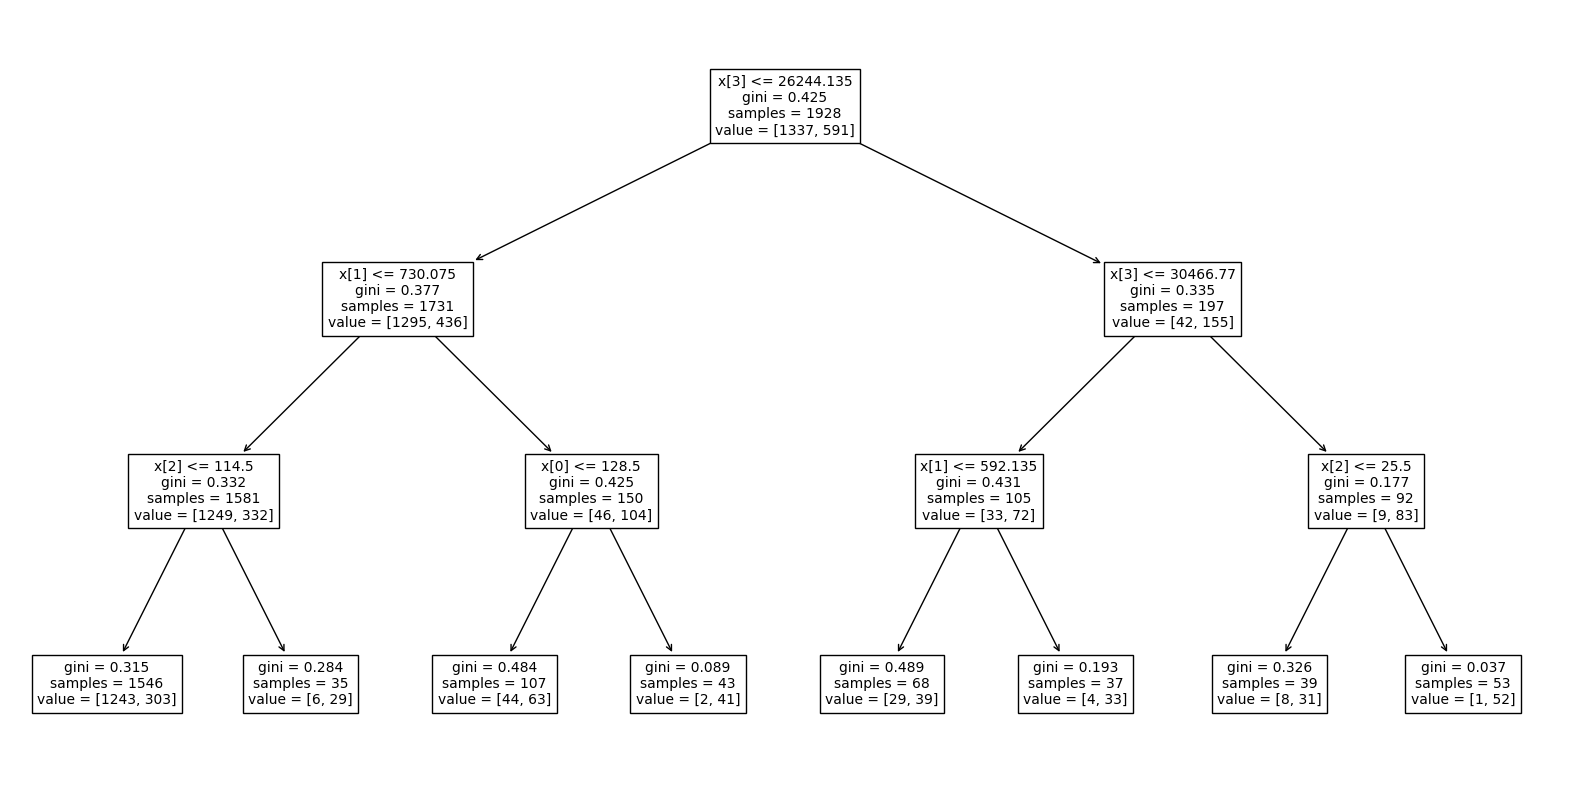

In [11]:
model = DecisionTreeClassifier(random_state=123, max_depth=3)  
model.fit(df_features_train, df_target_train) 
fig, axe = plt.subplots(figsize=(20,10))
tree.plot_tree(model, ax = axe, fontsize=10);

In [12]:
# выдергиваем максимальное значение из таблицы table_tree
best_tree = table_tree[table_tree['accuracy'] == table_tree['accuracy'].max()]
best_tree['model'] = ['decision tree']
best_tree

,max_depth,accuracy,model
4,5.0,0.816485,decision tree


Попробуем следующий алгоритм классификации — случайный лес (англ. random forest). Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

Для сравнения гиперпараметров, создадим отдельную таблицу, где будем смотреть наши параметры и точность:

In [13]:
# запустим цикл с перебором количества деревьев от 10 до 50 с шагом 10
table_forest = pd.DataFrame({'n_estimators':[], 'max_depth':[], 'accuracy':[]})
for est in tqdm(range(10, 51, 10)):
    # и глубины дерева от 1 до 10
    for depth in range (1, 11):
        row = []
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(df_features_train, df_target_train)
        predictions_valid = model.predict(df_features_valid)
        accuracy = accuracy_score(df_target_valid, predictions_valid)
        row.extend([est, depth, accuracy])
        table_forest.loc[len(table_forest.index)] = row

100%|███████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


In [14]:
table_forest.head(50)

,n_estimators,max_depth,accuracy
0,10.0,1.0,0.751166
1,10.0,2.0,0.782271
2,10.0,3.0,0.793157
3,10.0,4.0,0.821151
4,10.0,5.0,0.814930
5,10.0,6.0,0.814930
6,10.0,7.0,0.819596
7,10.0,8.0,0.832037
8,10.0,9.0,0.821151
9,10.0,10.0,0.810264


In [15]:
# выдергиваем максимальное значение из таблицы best_forest
best_forest = table_forest[table_forest['accuracy'] == table_forest['accuracy'].max()]
best_forest['model'] = 'random forest'
best_forest

,n_estimators,max_depth,accuracy,model
7,10.0,8.0,0.832037,random forest


Попробуем поэксперименторовать с гиперпараметрами, которые отвечают прежде всего за сложность модели.

— criterion='gini' — критерий Джини, который показывает меру сходства двух наборов данных. Обучаясь, дерево в каждом узле (на каждой развилке) из возможных вопросов задаёт наилучший. Сейчас оно выбирает тот вопрос, для которого критерий Джини показывает, что отнесённые к левой ветке данные меньше всего похожи на те, что в правой.  
— min_samples_leaf (от англ. «минимальное количество объектов в листе»). Листья — это нижние узлы с ответами. А гиперпараметр не разрешает создавать лист, в котором слишком мало объектов обучающей выборки.  
— bootstrap — это метод статистической повторной выборки, который включает случайную выборку набора данных с заменой.   

In [16]:
model = RandomForestClassifier(random_state=12345, n_estimators=est, criterion='entropy', max_depth=8)
model.fit(df_features_train, df_target_train)
predictions_valid = model.predict(df_features_valid)
accuracy = accuracy_score(df_target_valid, predictions_valid)
print('Количество деревьев', est,'Точность',accuracy)


Количество деревьев 50 Точность 0.8227060653188181


In [17]:
model = RandomForestClassifier(random_state=12345, n_estimators=est, bootstrap=False)
model.fit(df_features_train, df_target_train)
predictions_valid = model.predict(df_features_valid)
accuracy = accuracy_score(df_target_valid, predictions_valid)
print('Количество деревьев', est,'Точность',accuracy)

Количество деревьев 50 Точность 0.807153965785381


In [18]:
model = RandomForestClassifier(n_estimators=est, min_samples_leaf=5)
model.fit(df_features_train, df_target_train)
predictions_valid = model.predict(df_features_valid)
accuracy = accuracy_score(df_target_valid, predictions_valid)
print('Количество деревьев', est,'Точность',accuracy)


Количество деревьев 50 Точность 0.8195956454121306


Гиперпараметры, которые я взяла, в данной ситуации не дали результата, который превзошел бы параметры по умолчанию.

Посмотрим на графики с разной глубиной:

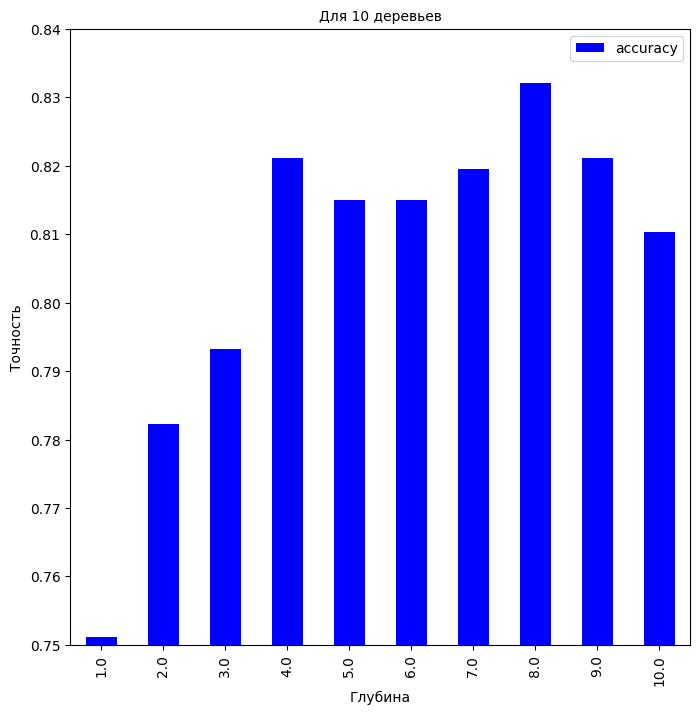

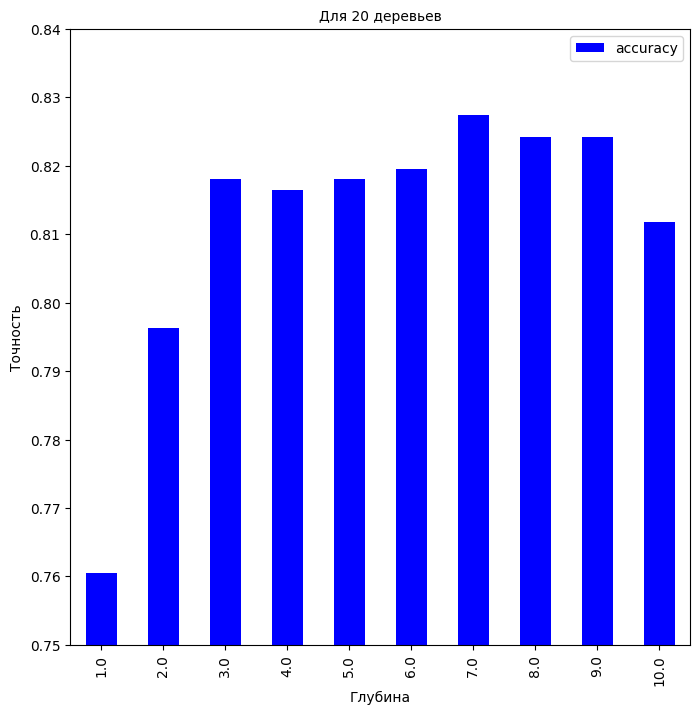

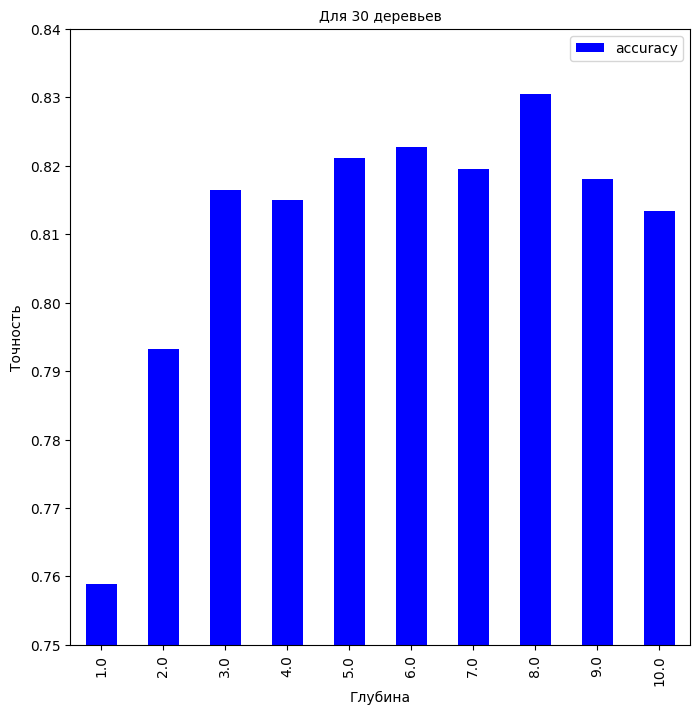

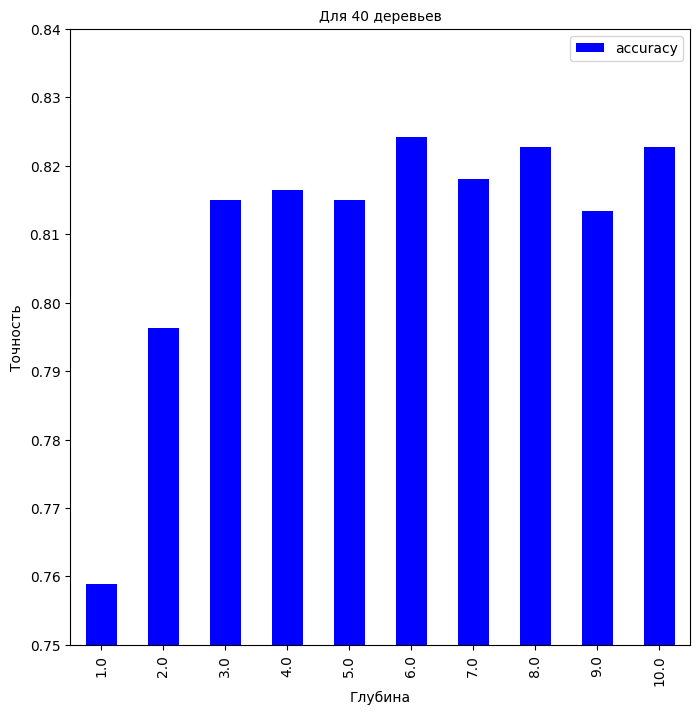

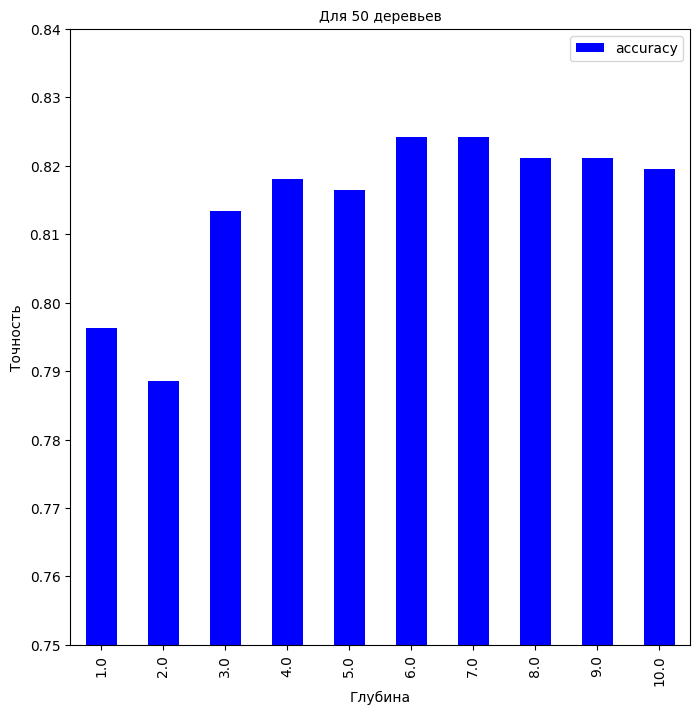

In [19]:
for est in range(10, 51, 10):
    table_forest
    table_forest[table_forest['n_estimators'] == est].plot.bar(x='max_depth', 
    y='accuracy', ylim=(0.75, 0.84), figsize=(8,8), color=('blue'))
    plt.ylabel('Точность', fontsize=10)
    plt.xlabel('Глубина', fontsize=10)
    plt.title(f'Для {est} деревьев', fontsize=10)
    plt.show()

Максимальная точность с количеством деревьев - 10 и глубиной - 8.



Рассмотрим следующий алгоритм машинного обучения — логистическая регрессия.

Если название и «мимикрирует» под задачу регрессии, всё-таки это алгоритм классификации. 
Логистическая регрессия:
Сначала считает, к какому классу близок объект.  
В зависимости от ответа выбирает нужный класс: если результат вычисления положительный, то — «1»; отрицательный — «0».  
В логистической регрессии параметров мало. Что-либо вызубрить по признакам в формуле не выйдет, поэтому и вероятность переобучения невелика.  


In [20]:
model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_log.fit(df_features_train, df_target_train)
answers_log = model_log.predict(df_features_valid)
accuracy_log = accuracy_score(df_target_valid, answers_log)

accuracy_log

0.7558320373250389

In [21]:
table_logistic = pd.DataFrame({'model': ['logistic regression'], 'accuracy': accuracy_log})
table_logistic

,model,accuracy
0,logistic regression,0.755832


Получили accuracy чуть ниже, но тоже неплохой результат, учитывая, что он больше 0.75.

## Проверьте модель на тестовой выборке

Мы рассмотрели три алгоритма машинного обучения. Выберем лучший!

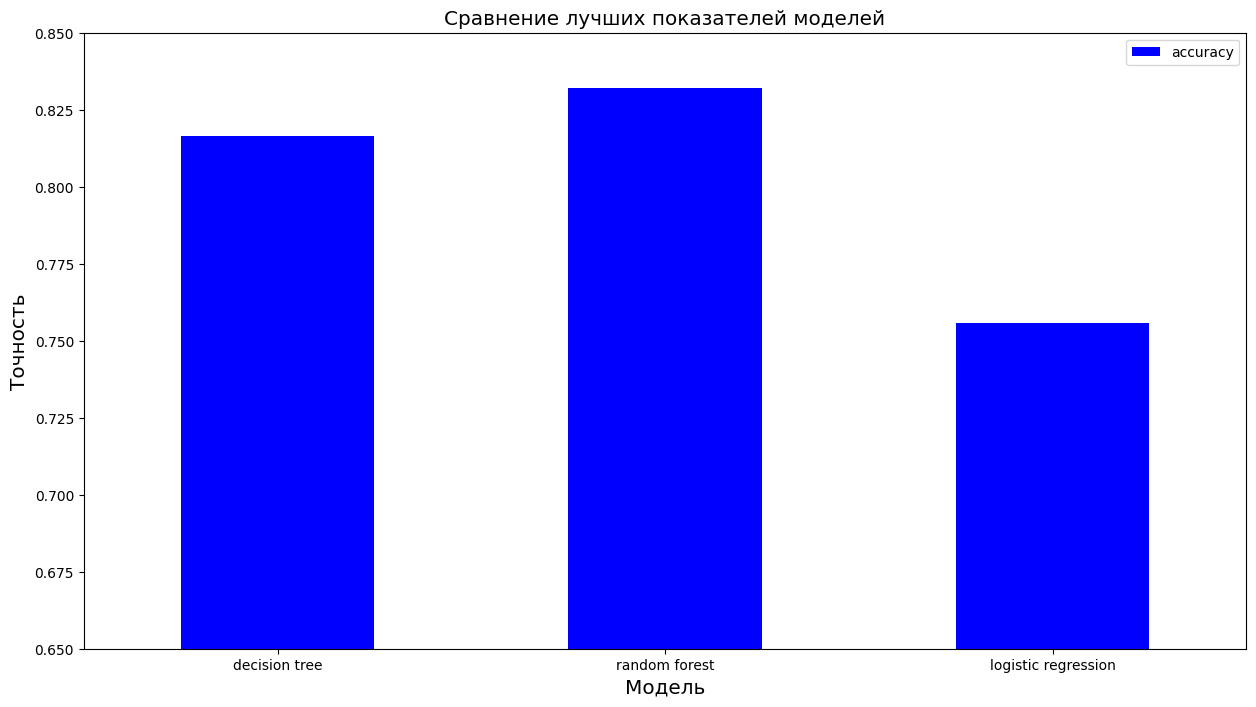

In [24]:
best_model = pd.DataFrame({'model':[], 'n_estimators':[], 'iterations':[], 'max_depth':[], 'accuracy':[]})
best_model = pd.concat([best_model, best_tree], ignore_index=True)
best_model = pd.concat([best_model, best_forest], ignore_index=True)
best_model = pd.concat([best_model, table_logistic], ignore_index=True)

best_model = best_model[['model', 'n_estimators', 'iterations', 'max_depth', 'accuracy']]

best_model.plot.bar(x='model', y='accuracy', rot=0, ylim=(0.65, 0.85), figsize=(15,8), color='blue')
plt.title('Сравнение лучших показателей моделей', fontsize='x-large')
plt.xlabel('Модель', fontsize='x-large')
plt.ylabel('Точность', fontsize='x-large')
plt.show()


Проверяем лучшую модель Random Forest на тестовой выборке.

In [25]:
model = RandomForestClassifier(random_state=12345,n_estimators=50, max_depth=10)
model.fit(df_features_train, df_target_train)
result = model.score(df_features_test, df_target_test) 
print("Accuracy модели:",result)

Accuracy модели: 0.8180404354587869


Вывод:

Лучшие показатели на тестовой выборке показала модель случайного леса с точностью 0.818040.

Для предсказаний, стоит пользоваться моделью случайного дерева с параметрами:  

количество - 50  
глубина - 10  

## Проверка модели на адекватность

In [29]:
adequacy_target_test = df_target_test.copy()
adequacy_target_test = adequacy_target_test.transform(lambda x: 0) 
print(f'Точность модели при заполнении более крупной группой - 0: {accuracy_score(df_target_test, adequacy_target_test)}')


Точность модели при заполнении более крупной группой - 0: 0.6936236391912908


Таким образом наша модель имеет большую вероятность правильного прогноза! 

In [30]:
large_group_fiction = DummyClassifier(strategy='most_frequent').fit(df_features_train, df_target_train)
more_frequent = large_group_fiction.predict(df_features_test)
print("Спрогнозированные метки: {}".format(np.unique(more_frequent)))
print("Тестовый набор: {:.2f}".format(large_group_fiction.score(df_features_test, df_target_test)))

Спрогнозированные метки: [0]
Тестовый набор: 0.69


##  Общий вывод:
Проект включает в себя следующие этапы:
Открытие и изучение файла с данными.
Разделение данных на обучающую, валидационную и тестовую выборки.
Исследование различных моделей, изменение гиперпараметров и сравнение их результатов.
Оценка качества лучшей модели на тестовой выборке.
Лучшие результаты показала модель случайного леса с точностью (accuracy) 0.818040.
Дополнительное задание: проверка моделей на вменяемость дала следующий результат: модель случайного леса показала точность при заполнении более крупной группой (0) равной 0.693623, что говорит о высокой вероятности правильных прогнозов, хотя следует также учитывать другие метрики и контекст задачи.
Итак, исследование проведено успешно, и важной является использование модели случайного леса с определенными гиперпараметрами (количество деревьев - 50, глубина - 10) для предсказаний. Модель показывает высокую точность на тестовой выборке.